In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import warnings

from pathlib import Path
from typing import cast

In [2]:
plt.style.use("seaborn-v0_8-muted")
plt.style.use("./sunlight-foundation.mplstyle")

In [3]:
np.random.seed(1)

# Ingest data

In [4]:
data_dir = Path("../data")

In [5]:
players = pd.read_csv(data_dir /"players.csv").set_index("id")
players.head()

,first_name,second_name,now_cost,name,short_name,position
id,,,,,,
384,Tom,Heaton,40,Man Utd,MUN,GKP
385,Dean,Henderson,45,Man Utd,MUN,GKP
17,Aaron,Ramsdale,50,Arsenal,ARS,GKP
18,Rúnar Alex,Rúnarsson,40,Arsenal,ARS,GKP
28,Matt,Turner,40,Arsenal,ARS,GKP


In [6]:
def load_player_csv(filepath: Path) -> pd.DataFrame:
    player_id = int(filepath.stem.split("_")[-1])
    df = pd.read_csv(filepath)
    df["id"] = player_id
    df["year_no"] = np.arange(1, df.shape[0] + 1)
    return df

def get_historic(player_id: int, df: pd.DataFrame) -> pd.DataFrame:
    subdf = df[df["id"] == player_id]
    return subdf.sort_values(by="year_no")

In [7]:
historic = pd.concat((load_player_csv(f) for f in data_dir.glob("p_*.csv"))).reset_index(drop=True).join(players, on="id")
historic["delta_cost"] = historic["end_cost"] - historic["start_cost"]

players = players[players.index.to_series().apply(lambda idx: idx in historic["id"].unique())]
historic.head()

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,expected_goals_conceded,id,year_no,first_name,second_name,now_cost,name,short_name,position,delta_cost
0,2020/21,214285,50,49,2,6,0,0,0,0,...,0.00,311,1,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-1
1,2021/22,214285,40,37,42,874,0,2,4,6,...,0.00,311,2,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-3
2,2022/23,214285,45,43,48,762,0,4,4,11,...,14.45,311,3,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-2
3,2022/23,441164,50,48,59,1132,3,3,2,26,...,19.42,506,1,Pedro,Porro,50,Spurs,TOT,DEF,-2
4,2021/22,231065,45,44,90,2694,1,1,7,43,...,0.00,112,1,Ethan,Pinnock,45,Brentford,BRE,DEF,-1


In [8]:
historic.columns

Index(['season_name', 'element_code', 'start_cost', 'end_cost', 'total_points',
       'minutes', 'goals_scored', 'assists', 'clean_sheets', 'goals_conceded',
       'own_goals', 'penalties_saved', 'penalties_missed', 'yellow_cards',
       'red_cards', 'saves', 'bonus', 'bps', 'influence', 'creativity',
       'threat', 'ict_index', 'starts', 'expected_goals', 'expected_assists',
       'expected_goal_involvements', 'expected_goals_conceded', 'id',
       'year_no', 'first_name', 'second_name', 'now_cost', 'name',
       'short_name', 'position', 'delta_cost'],
      dtype='object')

# Position comparison

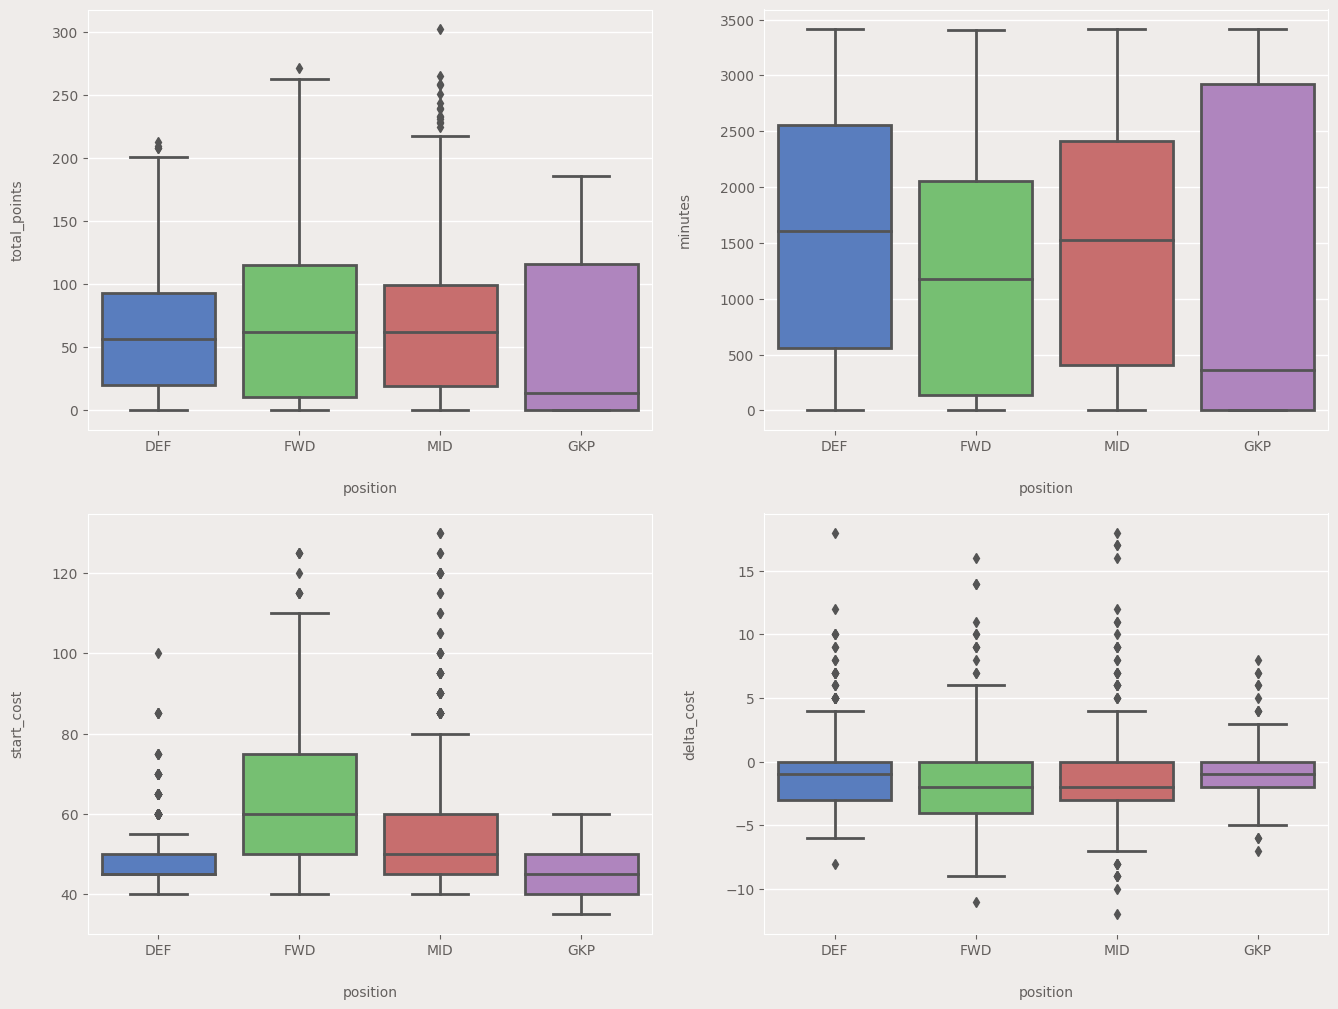

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
for ax, col in zip(axes.flatten(), ("total_points", "minutes", "start_cost", "delta_cost")):
    sns.boxplot(x="position", y=col, data=historic, ax=ax)

# How strongly do minutes and points correlate?

Text(0.5, 1.0, 'Player seasons with zero-minutes: 281/2083 (13.5%)')

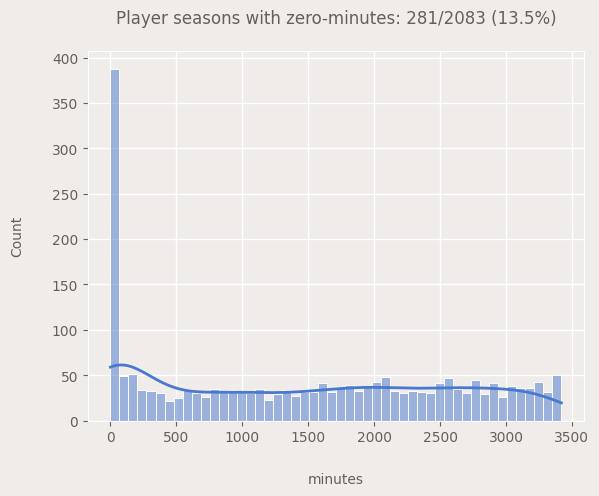

In [10]:
count_zero_mins = (historic["minutes"] == 0).sum()
fig, ax = plt.subplots()
sns.histplot(historic["minutes"], bins=50, kde=True, ax=ax)
plt.title(
    "Player seasons with zero-minutes: {cnt}/{tot} ({perc}%)".format(
        cnt=count_zero_mins,
        tot=historic.shape[0],
        perc=np.round(100*count_zero_mins/historic.shape[0], 1)
    )
)

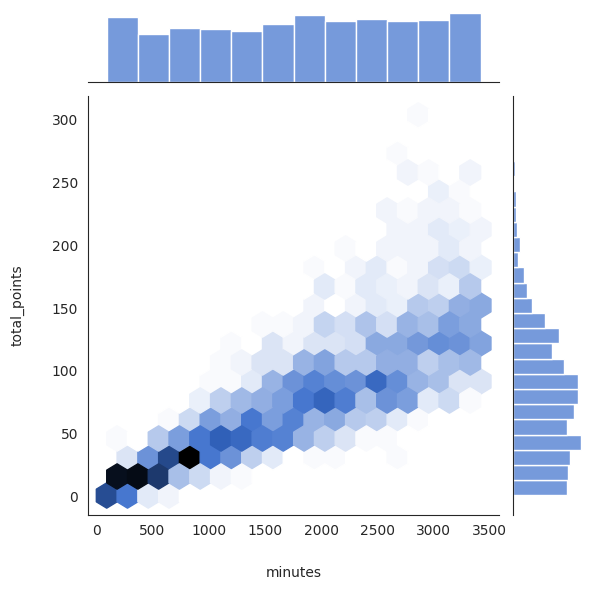

In [11]:
filter_less_than_mins = 90
with sns.axes_style("white"):
    sns.jointplot(x="minutes", y="total_points", data=historic[historic["minutes"]>filter_less_than_mins], kind="hex")

# Total Points vs Minutes

Check total points correlation with minutes played; filter out all players with less than "x" seasons.

In [12]:
seasons_required = 5
season_limit_mask = historic.groupby(by="id")["name"].count() > seasons_required
player_ids_with_season_limit = season_limit_mask.index[season_limit_mask]

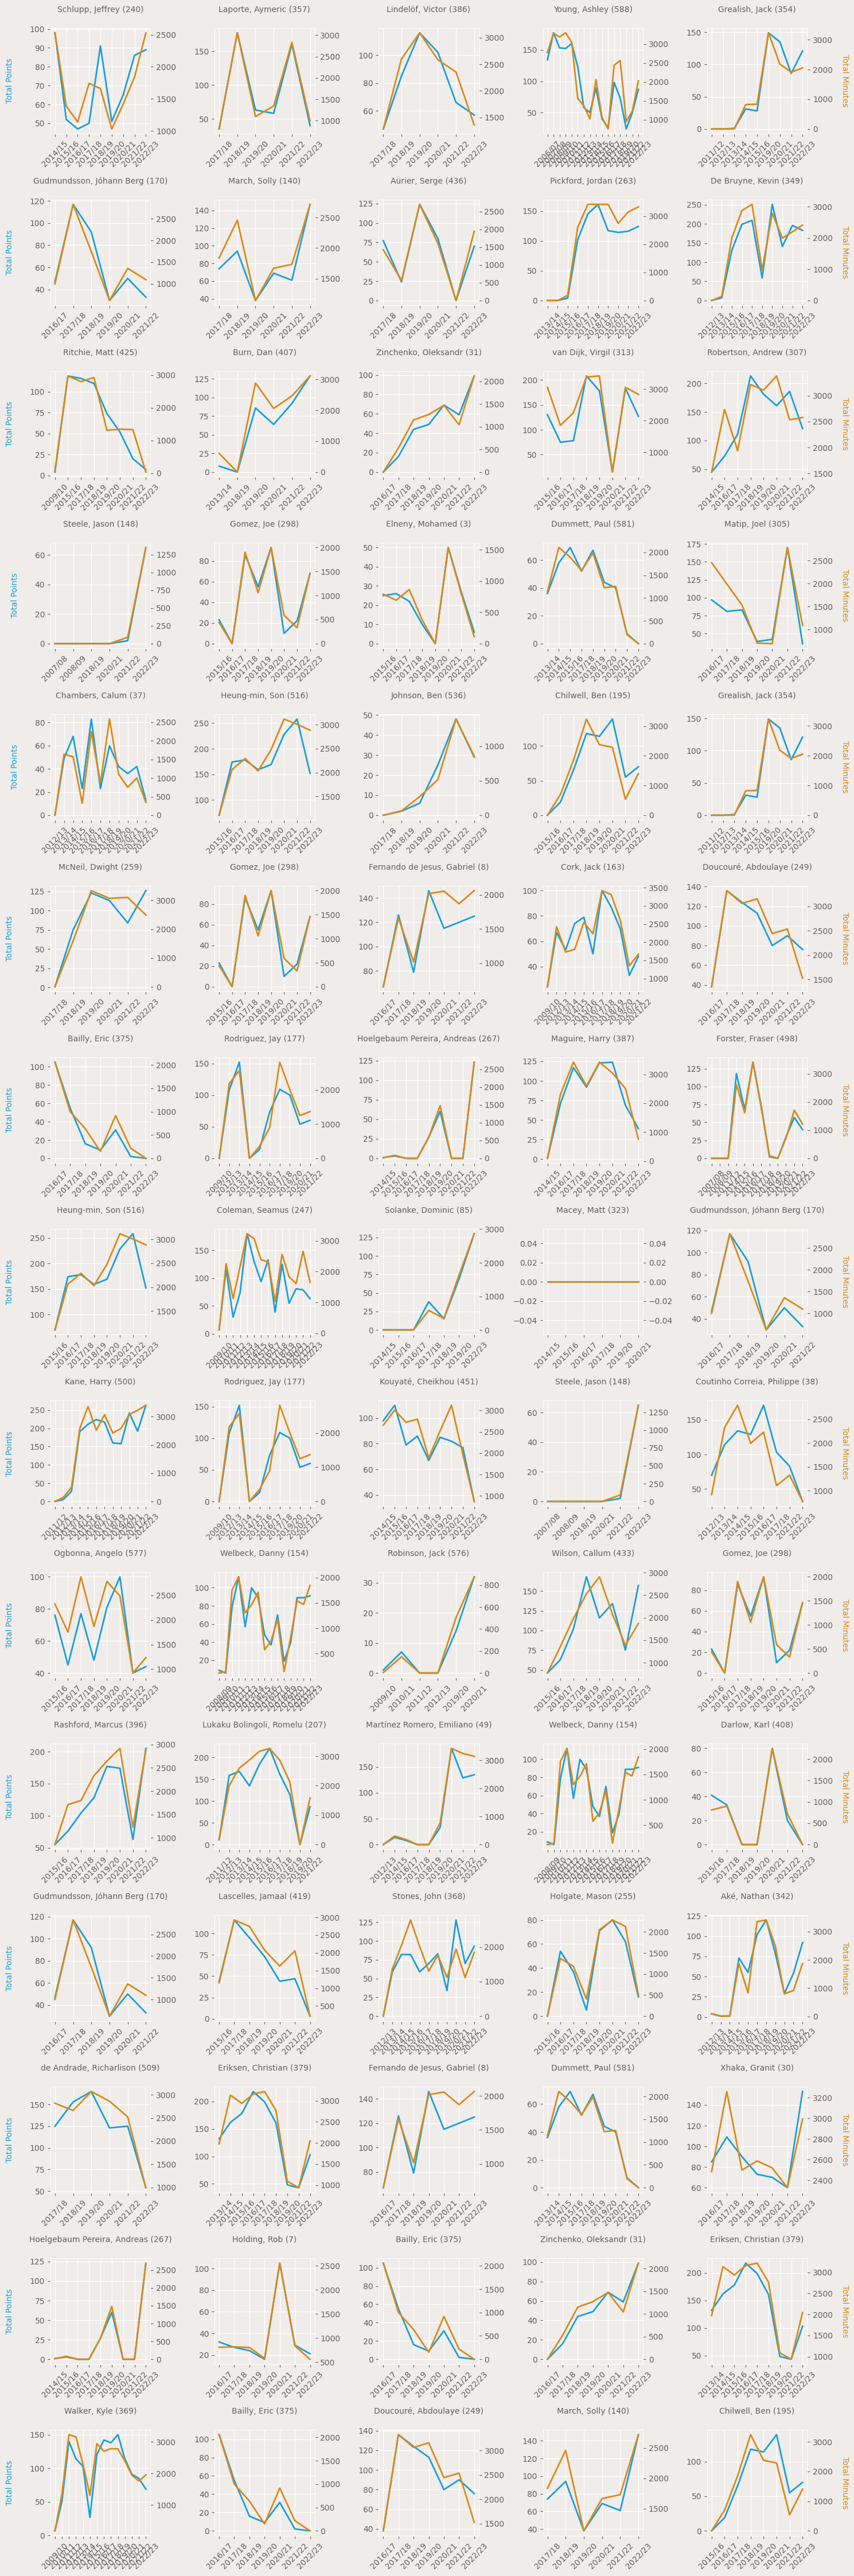

In [13]:
rows, cols = (5, 15)

random_players = np.random.choice(player_ids_with_season_limit, rows * cols)
fig, axes = plt.subplots(cols, rows, figsize=(rows*3, cols*3))

a_col = "#199FD9"
b_col = "#D98A19"

for i, player_id in enumerate(random_players):
    player_data = historic[historic["id"]==player_id]

    idx, idy = divmod(i, rows)
    ax_a = cast(plt.Axes, axes[idx, idy])
    ax_b = ax_a.twinx()
    ax_b.grid(visible=False)

    ax_a.plot("season_name", "total_points", data=player_data, c=a_col)
    ax_b.plot("season_name", "minutes", data=player_data, c=b_col)
    ax_a.set_title(
        f"{players.loc[player_id, 'second_name']}, {players.loc[player_id, 'first_name']} ({player_id})",
        fontdict={"fontsize": 10}
    )
    ax_a.tick_params(axis="x", labelrotation=45)

    if idy == 0:
        ax_a.set_ylabel("Total Points", fontdict={"color": a_col})
    elif idy == rows - 1:
        ax_b.set_ylabel("Total Minutes", fontdict={"color": b_col, "rotation": 270})

plt.tight_layout()

# Filter out first season with low minutes (comparatively)
#### Remove breakthrough years biasing average results.

In [14]:
def iglewicz_hoaglin(s: np.ndarray[int | float]) -> np.ndarray[float]:
    """Iglewicz and Hoaglin modified Z-score."""
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        s_median = np.median(s)
        mad = np.median(np.abs(s - s_median))
        return .6745 * (s - s_median) / mad

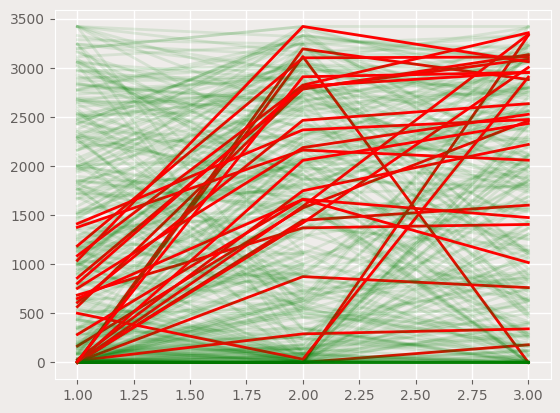

In [15]:
# Check working as expected
fig, ax = plt.subplots()
for player_id in players.index:
    player_data = historic[historic["id"] == player_id]
    zscore = iglewicz_hoaglin(player_data["minutes"])

    to_filter = False
    if list(zscore)[0] < -3.5:
        to_filter = True
    
    ax.plot(
        player_data["year_no"][:3],
        player_data["minutes"][:3],
        c = "r" if to_filter else "g",
        label = "FILTER" if to_filter else "KEEP",
        alpha=1 if to_filter else 0.1,
    )

plt.show()

# Weighted Points Average

Create a weighted points average bias towards recent seasons to optimise against.

In [16]:
def seasons_req_filter(players_data: pd.DataFrame, seasons_required: int) -> pd.DataFrame:
    is_req_met = (
        players_data[["id", "season_name"]].groupby("id").count() > seasons_required
    )["season_name"]
    return players_data[players_data["id"].apply(lambda player_id: is_req_met[player_id])].copy()

In [17]:
historic_filtered = seasons_req_filter(players_data=historic, seasons_required=1)
historic_filtered["year_no_points_multiplier"] = historic_filtered["year_no"] * historic_filtered["total_points"]
historic_filtered = historic_filtered.set_index("id")

In [18]:
historic_filtered

,season_name,element_code,start_cost,end_cost,total_points,minutes,goals_scored,assists,clean_sheets,goals_conceded,...,expected_goals_conceded,year_no,first_name,second_name,now_cost,name,short_name,position,delta_cost,year_no_points_multiplier
id,,,,,,,,,,,,,,,,,,,,,
311,2020/21,214285,50,49,2,6,0,0,0,0,...,0.00,1,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-1,2
311,2021/22,214285,40,37,42,874,0,2,4,6,...,0.00,2,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-3,84
311,2022/23,214285,45,43,48,762,0,4,4,11,...,14.45,3,Konstantinos,Tsimikas,45,Liverpool,LIV,DEF,-2,144
112,2021/22,231065,45,44,90,2694,1,1,7,43,...,0.00,1,Ethan,Pinnock,45,Brentford,BRE,DEF,-1,90
112,2022/23,231065,45,44,112,2700,3,0,10,34,...,40.17,2,Ethan,Pinnock,45,Brentford,BRE,DEF,-1,224
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207,2016/17,66749,90,101,221,3266,25,6,13,42,...,0.00,6,Romelu,Lukaku Bolingoli,70,Chelsea,CHE,FWD,11,1326
207,2017/18,66749,115,115,162,2866,16,7,14,26,...,0.00,7,Romelu,Lukaku Bolingoli,70,Chelsea,CHE,FWD,0,1134
207,2018/19,66749,110,107,115,2126,12,1,4,38,...,0.00,8,Romelu,Lukaku Bolingoli,70,Chelsea,CHE,FWD,-3,920


In [34]:
aggregates = historic_filtered[["total_points", "minutes"]].groupby(by=historic_filtered.index)\
    .mean().rename(columns={"total_points": "points_flat_avg", "minutes": "minutes_flat_avg"})

I can't do this because I'm going to just bias the results to people who have been in the leage the longest.

In [35]:
aggregates = aggregates.join(
    historic_filtered.groupby(by=historic_filtered.index)
    .agg({"year_no_points_multiplier": "sum", "year_no": "sum"})
    .rename(columns={"year_no_points_multiplier": "yr_pts_avg", "year_no": "year_no_sum"})
    )
aggregates["points_bias_recent_avg"] = aggregates["yr_pts_avg"] / aggregates["year_no_sum"]

In [36]:
aggregates.sort_values("points_bias_recent_avg", ascending=False).join(players[["second_name", "short_name", "position"]])

,points_flat_avg,minutes_flat_avg,yr_pts_avg,year_no_sum,points_bias_recent_avg,second_name,short_name,position
id,,,,,,,,
308,195.500000,2337.125,8300,36,230.555556,Salah,LIV,MID
500,157.583333,2242.750,15166,78,194.435897,Kane,TOT,FWD
516,173.500000,2373.375,6823,36,189.527778,Heung-min,TOT,MID
373,172.000000,2678.750,1762,10,176.200000,Borges Fernandes,MUN,MID
290,144.285714,2311.000,4709,28,168.178571,Alexander-Arnold,LIV,DEF
...,...,...,...,...,...,...,...,...
136,0.000000,0.000,0,3,0.000000,Karbownik,BHA,DEF
97,0.000000,0.000,0,3,0.000000,Cox,BRE,GKP
491,0.000000,0.000,0,6,0.000000,Austin,TOT,GKP


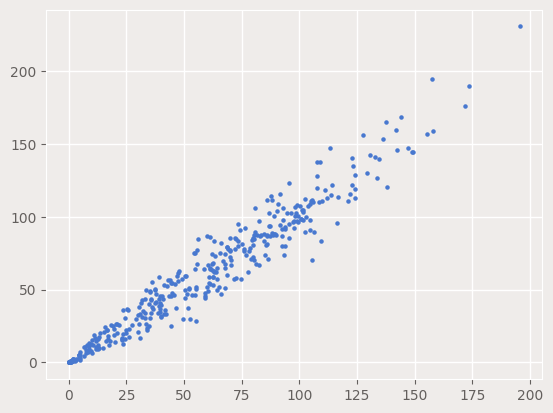

In [37]:
fig, ax = plt.subplots()
ax.scatter(x="points_flat_avg", y="points_bias_recent_avg", data=aggregates, s=5)

# Test against last year's data

In [54]:
from ff_epl.optimisation import optimise

Calculate last year's best team.

In [71]:
last_year_points = players.rename(columns={"short_name": "club"})\
    .join(historic[historic["season_name"] == "2022/23"][["id", "total_points"]].set_index("id"), how="inner")\
    .reset_index()
last_year_points["injured"] = 0
last_year_points["now_cost"] = last_year_points["now_cost"] / 10

In [72]:
decision_vars, mdl = optimise.generate_model(last_year_points, optimisation_metric="total_points")
mdl.solve()

SV = [bool(int(dv.value())) for dv in decision_vars]  # Solution Vector

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ehutchinson/projects/fantasy-football-epl/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/b56ab2b2ecfc4da496a5d871be8a9998-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/b56ab2b2ecfc4da496a5d871be8a9998-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 35 COLUMNS
At line 3819 RHS
At line 3850 BOUNDS
At line 4316 ENDATA
Problem MODEL has 30 rows, 465 columns and 2471 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 2082.07 - 0.00 seconds
Cgl0004I processed model has 23 rows, 423 columns (423 integer (405 of which binary)) and 1599 elements
Cutoff increment increased from 1e-05 to 0.9999
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.266667
Cbc0038I Solution found of -2067
Cbc0038I Cleaned solution of -2067
Cbc0038I Before mini branc

In [73]:
last_year_points[SV]

,id,first_name,second_name,now_cost,name,club,position,total_points,injured
47,113,David,Raya Martin,5.0,Brentford,BRE,GKP,166,0
79,430,Kieran,Trippier,6.5,Newcastle,NEW,DEF,198,0
100,51,Tyrone,Mings,4.5,Aston Villa,AVL,DEF,130,0
203,109,Ben,Mee,5.0,Brentford,BRE,DEF,143,0
219,396,Marcus,Rashford,9.0,Man Utd,MUN,MID,205,0
227,12,Gabriel,Martinelli Silva,8.0,Arsenal,ARS,MID,198,0
228,14,Martin,Ødegaard,8.5,Arsenal,ARS,MID,212,0
231,19,Bukayo,Saka,8.5,Arsenal,ARS,MID,202,0
419,500,Harry,Kane,12.5,Spurs,TOT,FWD,263,0
423,60,Ollie,Watkins,8.0,Aston Villa,AVL,FWD,175,0


In [78]:
print(f"Total Cost = £{last_year_points[SV]['now_cost'].sum(): .2f}, Points = {last_year_points[SV]['total_points'].sum()}")

Total Cost = £ 83.50, Points = 2074


Calculate selection without last year's data using different metrics; i.e. team we would have picked.

#### Flat Average:

In [85]:
point_map = last_year_points.set_index("id")["total_points"]

In [61]:
df = seasons_req_filter(
    players_data=historic[historic["season_name"] == "2022/23"],
    seasons_required=1
)
df["year_no_points_multiplier"] = df["year_no"] * df["total_points"]
df = df.set_index("id")

test_aggregates = historic_filtered[["total_points", "minutes"]].groupby(by=historic_filtered.index)\
    .mean().rename(columns={"total_points": "points_flat_avg", "minutes": "minutes_flat_avg"})

test_aggregates = test_aggregates.join(
    historic_filtered.groupby(by=historic_filtered.index)
    .agg({"year_no_points_multiplier": "sum", "year_no": "sum"})
    .rename(columns={"year_no_points_multiplier": "yr_pts_avg", "year_no": "year_no_sum"})
    )

test_aggregates["points_bias_recent_avg"] = test_aggregates["yr_pts_avg"] / test_aggregates["year_no_sum"]

out = players.rename(columns={"short_name": "club"})\
    .join(test_aggregates[["points_flat_avg", "minutes_flat_avg", "points_bias_recent_avg"]], how="inner")\
    .reset_index()

out["injured"] = 0
out["now_cost"] = out["now_cost"] / 10

In [79]:
decision_vars, mdl = optimise.generate_model(out, optimisation_metric="points_flat_avg")
mdl.solve()

SV = [bool(int(dv.value())) for dv in decision_vars]  # Solution Vector

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ehutchinson/projects/fantasy-football-epl/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/76b357a116c74a839c388c41eab575e5-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/76b357a116c74a839c388c41eab575e5-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 3296 RHS
At line 3329 BOUNDS
At line 3725 ENDATA
Problem MODEL has 32 rows, 395 columns and 2100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1671.45 - 0.00 seconds
Cgl0004I processed model has 26 rows, 377 columns (377 integer (377 of which binary)) and 1417 elements
Cbc0038I Initial state - 4 integers unsatisfied sum - 1.66667
Cbc0038I Solution found of -1659.2
Cbc0038I Before mini branch and bound, 373 integers at bound fixed and 0 continuous
Cbc0038I Full problem 26

In [80]:
out[SV]

,id,first_name,second_name,now_cost,name,club,position,points_flat_avg,minutes_flat_avg,points_bias_recent_avg,injured
37,352,Ederson,Santana de Moraes,5.5,Man City,MCI,GKP,149.333333,3234.333333,144.571429,0
58,5,Gabriel,dos Santos Magalhães,5.0,Arsenal,ARS,DEF,123.333333,2822.666667,134.666667,0
93,189,César,Azpilicueta,4.5,Chelsea,CHE,DEF,122.090909,2669.090909,115.727273,0
112,290,Trent,Alexander-Arnold,8.0,Liverpool,LIV,DEF,144.285714,2311.000000,168.178571,0
117,307,Andrew,Robertson,6.5,Liverpool,LIV,DEF,136.375000,2628.625000,153.250000,0
187,373,Bruno,Borges Fernandes,8.5,Man Utd,MUN,MID,172.000000,2678.750000,176.200000,0
230,504,James,Maddison,7.5,Spurs,TOT,MID,142.200000,2496.200000,145.666667,0
234,516,Son,Heung-min,9.0,Spurs,TOT,MID,173.500000,2373.375000,189.527778,0
270,308,Mohamed,Salah,12.5,Liverpool,LIV,MID,195.500000,2337.125000,230.555556,0
313,359,Riyad,Mahrez,7.5,Man City,MCI,MID,148.888889,2166.333333,144.688889,0


In [87]:
print(f"Total Cost = £{out[SV]['now_cost'].sum(): .2f}, Points = {sum([point_map.loc[player_id] for player_id in out[SV]['id']])}")

Total Cost = £ 82.50, Points = 1592


#### Recent Bias:

In [88]:
decision_vars, mdl = optimise.generate_model(out, optimisation_metric="points_bias_recent_avg")
mdl.solve()

SV = [bool(int(dv.value())) for dv in decision_vars]  # Solution Vector

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ehutchinson/projects/fantasy-football-epl/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/ea27352cbb2c4fb98ea395f7e9a509f0-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/ea27352cbb2c4fb98ea395f7e9a509f0-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 3296 RHS
At line 3329 BOUNDS
At line 3725 ENDATA
Problem MODEL has 32 rows, 395 columns and 2100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 1799.8 - 0.00 seconds
Cgl0004I processed model has 26 rows, 376 columns (376 integer (375 of which binary)) and 1414 elements
Cbc0038I Initial state - 2 integers unsatisfied sum - 0.666667
Cbc0038I Solution found of -1773.57
Cbc0038I Cleaned solution of -1773.57
Cbc0038I Before mini branch and bound, 374 integers at bound fixed an

In [89]:
out[SV]

,id,first_name,second_name,now_cost,name,club,position,points_flat_avg,minutes_flat_avg,points_bias_recent_avg,injured
34,569,José,Malheiro de Sá,5.0,Wolves,WOL,GKP,147.000000,3262.500000,147.333333,0
58,5,Gabriel,dos Santos Magalhães,5.0,Arsenal,ARS,DEF,123.333333,2822.666667,134.666667,0
93,189,César,Azpilicueta,4.5,Chelsea,CHE,DEF,122.090909,2669.090909,115.727273,0
112,290,Trent,Alexander-Arnold,8.0,Liverpool,LIV,DEF,144.285714,2311.000000,168.178571,0
117,307,Andrew,Robertson,6.5,Liverpool,LIV,DEF,136.375000,2628.625000,153.250000,0
187,373,Bruno,Borges Fernandes,8.5,Man Utd,MUN,MID,172.000000,2678.750000,176.200000,0
202,14,Martin,Ødegaard,8.5,Arsenal,ARS,MID,127.666667,2258.333333,156.333333,0
234,516,Son,Heung-min,9.0,Spurs,TOT,MID,173.500000,2373.375000,189.527778,0
252,216,Raheem,Sterling,7.0,Chelsea,CHE,MID,142.083333,2168.250000,159.294872,0
270,308,Mohamed,Salah,12.5,Liverpool,LIV,MID,195.500000,2337.125000,230.555556,0


In [90]:
print(f"Total Cost = £{out[SV]['now_cost'].sum(): .2f}, Points = {sum([point_map.loc[player_id] for player_id in out[SV]['id']])}")

Total Cost = £ 82.50, Points = 1671


#### Minutes Flat Average

In [91]:
decision_vars, mdl = optimise.generate_model(out, optimisation_metric="minutes_flat_avg")
mdl.solve()

SV = [bool(int(dv.value())) for dv in decision_vars]  # Solution Vector

Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Dec 15 2019 

command line - /home/ehutchinson/projects/fantasy-football-epl/.venv/lib/python3.11/site-packages/pulp/solverdir/cbc/linux/64/cbc /tmp/8af7189a556f45e5915f72fe9441cc5c-pulp.mps max timeMode elapsed branch printingOptions all solution /tmp/8af7189a556f45e5915f72fe9441cc5c-pulp.sol (default strategy 1)
At line 2 NAME          MODEL
At line 3 ROWS
At line 37 COLUMNS
At line 3296 RHS
At line 3329 BOUNDS
At line 3725 ENDATA
Problem MODEL has 32 rows, 395 columns and 2100 elements
Coin0008I MODEL read with 0 errors
Option for timeMode changed from cpu to elapsed
Continuous objective value is 32585.8 - 0.00 seconds
Cgl0004I processed model has 26 rows, 377 columns (377 integer (377 of which binary)) and 1417 elements
Cbc0038I Initial state - 0 integers unsatisfied sum - 0
Cbc0038I Solution found of -32585.8
Cbc0038I Before mini branch and bound, 377 integers at bound fixed and 0 continuous
Cbc0038I Mini branch and boun

In [92]:
out[SV]

,id,first_name,second_name,now_cost,name,club,position,points_flat_avg,minutes_flat_avg,points_bias_recent_avg,injured
34,569,José,Malheiro de Sá,5.0,Wolves,WOL,GKP,147.000000,3262.500000,147.333333,0
58,5,Gabriel,dos Santos Magalhães,5.0,Arsenal,ARS,DEF,123.333333,2822.666667,134.666667,0
136,129,Lewis,Dunk,5.0,Brighton,BHA,DEF,108.333333,3091.000000,110.238095,0
156,473,George,Baldock,4.0,Sheffield Utd,SHU,DEF,102.500000,3103.500000,89.333333,0
178,103,Rico,Henry,4.5,Brentford,BRE,DEF,110.000000,3007.500000,110.666667,0
179,109,Ben,Mee,5.0,Brentford,BRE,DEF,98.375000,2826.750000,102.750000,0
239,43,Douglas Luiz,Soares de Paulo,5.5,Aston Villa,AVL,MID,98.250000,2755.500000,106.900000,0
241,50,John,McGinn,5.5,Aston Villa,AVL,MID,99.500000,2856.000000,100.200000,0
287,231,Jefferson,Lerma Solís,5.0,Crystal Palace,CRY,MID,80.333333,2819.666667,84.666667,0
345,108,Bryan,Mbeumo,6.5,Brentford,BRE,MID,134.500000,2905.000000,139.666667,0


In [93]:
print(f"Total Cost = £{out[SV]['now_cost'].sum(): .2f}, Points = {sum([point_map.loc[player_id] for player_id in out[SV]['id']])}")

KeyError: 473

# Data out

In [14]:
# Find players where first season should be filtered out
# to avoid biasing averages by breakthrough year.
p_filter_first = []
for i in players.index:
    pdata = _p[_p['id'] == i]
    zscore = iglewicz_hoaglin(pdata['minutes'])
    try:
        if list(zscore)[0] < -3.5:
            p_filter_first.append(i)
    except IndexError:
        continue
print(p_filter_first)


[352, 170, 146, 288, 429, 98, 276, 291, 309, 173, 233, 341, 406, 421, 386, 250, 255, 529]


In [15]:
# Create boolean mask and filter player data DataFrame.
# Also -=1 from all seasons, assume second season as first.
id_minseason = _p.groupby('id').min()['season_name']
_p['keep'] = True
for i, ms in id_minseason.items():
    if i in p_filter_first:
        mask_id = (_p['id']==i)
        mask_minseason = _p['season_name'] == ms
        _p.loc[_p[mask_id].index, 'season_number'] -= 1
        _p.loc[_p[mask_id & mask_minseason].index, 'keep'] = False
_p = _p[_p['keep']]

In [16]:
# Weighted average total points, biased to recent seasons.
sum_seasons = _p.groupby('id')['season_number'].transform('sum')
_p['weighted_points'] = _p['total_points'] * (1 + (_p['season_number'] / sum_seasons))

In [17]:
points = _p[['id', 'total_points', 'weighted_points']].groupby('id').mean()
points.head()

,total_points,weighted_points
id,,
1,117.000,157.388889
2,1.000,2.000000
3,114.875,129.628472
4,157.000,197.900000
5,69.000,78.730159


117.0
157.38888888888889


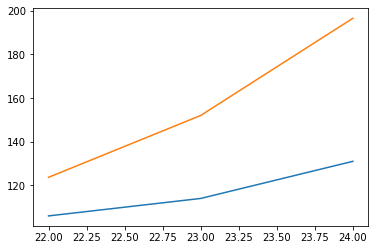

In [18]:
#  Checking...
fig, ax = plt.subplots()
i = 1
_ = _p[(_p['id'] == i)]
ax.plot(_['total_points'])
ax.plot(_['total_points'] * (1 + (_['season_number'] / _['season_number'].sum())))
print(_['total_points'].mean())
print((_['total_points'] * (1 + (_['season_number'] / _['season_number'].sum()))).mean())

In [19]:
players.join(points, how='inner').rename(
    columns={'short_name': 'club'}
    ).to_csv('../data/player_points.csv')